In [1]:
library(tidyverse)
library(repr)
library(tidymodels)

options(repr.matrix.max.rows = 6)

install.packages("themis")
library(themis)


Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
url <- "https://raw.githubusercontent.com/zayan-sheikh/DSCI-G13-Project/main/data/waterQuality1.csv"
raw_data <- read_csv(url) |>
            mutate(is_safe = as_factor(is_safe))|>
            mutate(is_safe = fct_recode(is_safe, 'safe' = '1', 'not safe' = '0')) |>
            select(arsenic, bacteria, viruses, lead, nitrates, nitrites, is_safe) |>
            na.omit()

head(raw_data)

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 7999 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (21): aluminium, ammonia, arsenic, barium, cadmium, chloramine, chromium...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


arsenic,bacteria,viruses,lead,nitrates,nitrites,is_safe
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.04,0.20,0.000,0.054,16.08,1.13,safe
0.01,0.65,0.650,0.100,2.01,1.93,safe
0.04,0.05,0.003,0.078,14.16,1.11,not safe
0.04,0.71,0.710,0.016,1.41,1.29,safe
0.03,0.13,0.001,0.117,6.74,1.11,safe
0.03,0.67,0.670,0.135,9.75,1.89,safe


In [3]:
water_split <- initial_split(raw_data, prop = 0.75, strata = is_safe)
water_train <- training(water_split)
water_test <- testing(water_split)

In [150]:
set.seed(1)
water_wrangled <- water_train |>
                    pivot_longer(cols = arsenic:nitrites, names_to = "contaminant", values_to = "level")

water_means <- water_wrangled |> 
                     na.omit(skip = TRUE) |>
                     group_by(contaminant)|>
                     summarize(average_value = mean(level))

water_means

# Manipulating data to get number of observations for each class
water_train_table <- water_train |> 
                     group_by(is_safe)|>
                     summarize(count = n())

water_train_table


contaminant,average_value
<chr>,<dbl>
arsenic,0.16007054
bacteria,0.32023845
lead,0.09923478
nitrates,9.79790562
nitrites,1.32354844
viruses,0.32866650


is_safe,count
<fct>,<int>
not safe,5313
safe,684


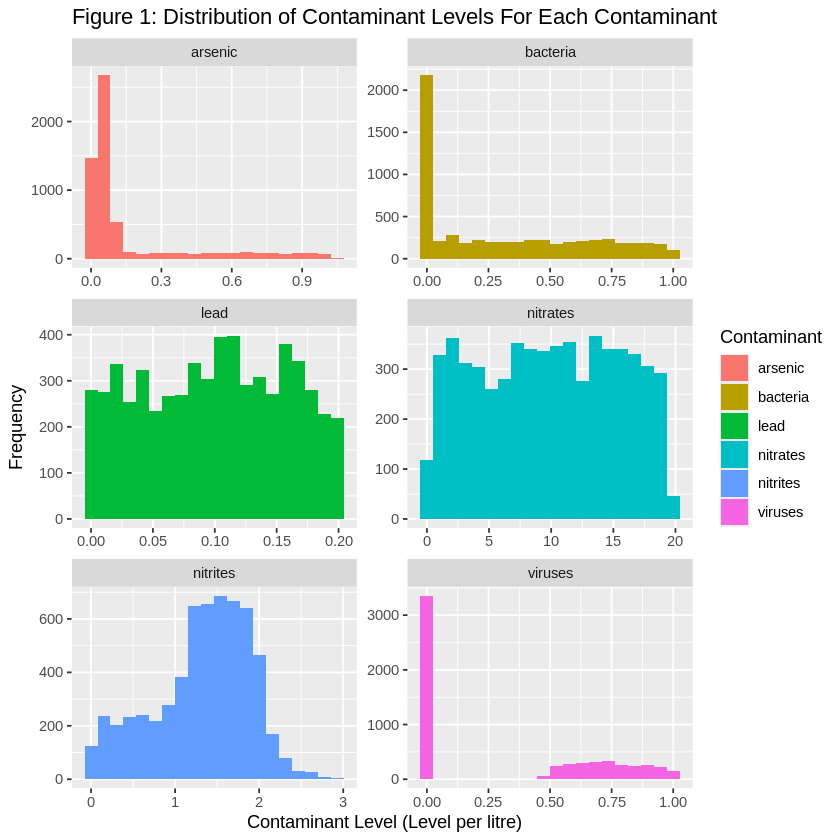

In [151]:
water_train_plot <- water_wrangled |>
                    ggplot(aes(x=level, fill = contaminant)) +
                    geom_histogram(bins = 20) +
                    facet_wrap(vars(contaminant), scales = "free", nrow = 3) +
                    labs(x=" Contaminant Level (Level per litre)", y="Frequency", fill="Contaminant") +
                    ggtitle("Figure 1: Distribution of Contaminant Levels For Each Contaminant")

water_train_plot

In [152]:
set.seed(1)
# step 1: create a recipe for the training data. Since the data is imbalanced, we must import the themis library and upsample the data first.

water_temp <- recipe(is_safe ~ arsenic + bacteria + viruses + lead + nitrates + nitrites, data = water_train) |>
    step_naomit(all_predictors(), skip=TRUE) |>
    step_upsample(is_safe, over_ratio = 1, skip = FALSE) |>
    prep()

# step 2: using the upsampled data, we will create a "new" dataset for us to use
water_ups <- bake(water_temp, water_train)


# step 3: using the upsampled dataset, create a recipe, scaling and centering all predictors
water_recipe <- recipe(is_safe ~ arsenic + bacteria + viruses + lead + nitrates + nitrites, data = water_ups) |>
    step_scale(all_predictors())|>
    step_center(all_predictors()) |>
    prep()
    

# chechking to see if dataset is now balanced
water_ups |>
  group_by(is_safe) |>
  summarize(n = n())

water_recipe

is_safe,n
<fct>,<int>
not safe,5313
safe,5313




── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 6



── Training information 

Training data contained 10626 data points and no incomplete rows.



── Operations 

• Scaling for: arsenic, bacteria, viruses, lead, nitrates, nitrites | Trained

• Centering for: arsenic, bacteria, viruses, lead, nitrates, nitrites | Trained



In [153]:
set.seed(1)
#step 2: create a multiple training datasets to perform cross validation

water_vfold <- vfold_cv(water_ups, v = 5, strata = is_safe)

In [154]:
#step 3: create a classification model that allows us to tune the number of neighbors

water_knn <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine('kknn') |>
    set_mode('classification')

In [155]:
set.seed(1)
#step 4: create a workflow that combines the recipe, model specification and that performs the vfold cross validation
grid_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 2))


knn_workflow <- workflow() |>
    add_recipe(water_recipe) |>
    add_model(water_knn) |>
    tune_grid(resamples = water_vfold, grid = grid_vals)

In [156]:
set.seed(1)
#step 5: collect the metrics to allow us to determine which k value is most resonable

knn_results <- knn_workflow |>
    collect_metrics()
print(knn_results)

# A tibble: 10 × 7
   neighbors .metric  .estimator  mean     n std_err .config             
       <dbl> <chr>    <chr>      <dbl> <int>   <dbl> <chr>               
 1         1 accuracy binary     0.813     5 0.00515 Preprocessor1_Model1
 2         1 roc_auc  binary     0.813     5 0.00515 Preprocessor1_Model1
 3         3 accuracy binary     0.870     5 0.00421 Preprocessor1_Model2
 4         3 roc_auc  binary     0.891     5 0.00391 Preprocessor1_Model2
 5         5 accuracy binary     0.825     5 0.00350 Preprocessor1_Model3
 6         5 roc_auc  binary     0.882     5 0.00334 Preprocessor1_Model3
 7         7 accuracy binary     0.792     5 0.00215 Preprocessor1_Model4
 8         7 roc_auc  binary     0.860     5 0.00561 Preprocessor1_Model4
 9         9 accuracy binary     0.764     5 0.00464 Preprocessor1_Model5
10         9 roc_auc  binary     0.837     5 0.00479 Preprocessor1_Model5


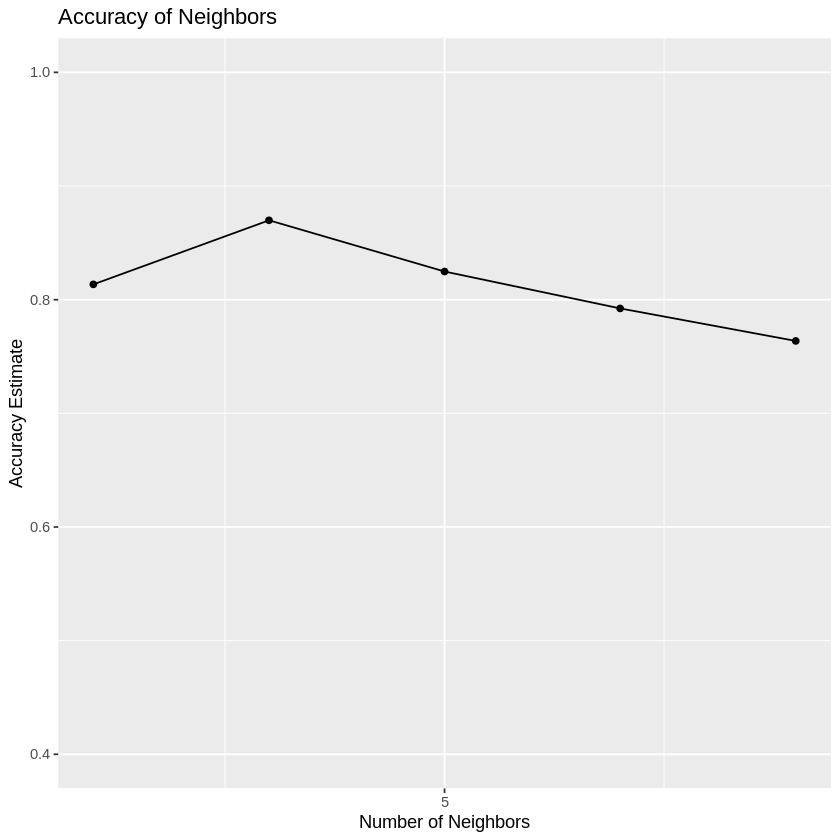

In [157]:
#this plot depicts the accuracy of the model at each given value of n nearest neighbors
water_accuracy <- knn_results |>
    filter(.metric == 'accuracy')

recall_plot <- ggplot(water_accuracy, aes(x = neighbors, y = mean))+ 
                      geom_point()+
                      geom_line()+
                      labs(x = 'Number of Neighbors', y = 'Accuracy Estimate')+
                      ggtitle('Accuracy of Neighbors')+
                    scale_x_continuous(breaks = seq(0, 51, by = 5))+
                    scale_y_continuous(limits = c(0.4, 1.0))
                        
recall_plot

In [158]:
#determine which k value gives the most accurate model:

best_3_accuracy <- water_accuracy|>
    arrange(desc(mean))|>
    head(3)|>
    pull(neighbors)

best_3_accuracy

[1] 3 5 1

This plot indicates that the most accurate model to predict whether the water is safe or not is a model with either 1, 3, or 5 nearest neighbors. We will be performing three seperate tests on three models with these values of n, to determine which is most applicable to our problem.

In [159]:
set.seed(1)
#model 1 (1 nearest neighbor):

water_knn_1 <- nearest_neighbor(weight_func = 'rectangular', neighbors = 1) |>
    set_engine('kknn') |>
    set_mode('classification')

knn_workflow_1 <- workflow() |>
    add_recipe(water_recipe) |>
    add_model(water_knn_1) |>
    fit(data = water_train)

test_pred_1 <- predict(knn_workflow_1, water_test)|>
    bind_cols(water_test)
test_pred_1

.pred_class,arsenic,bacteria,viruses,lead,nitrates,nitrites,is_safe
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
not safe,0.040,0.20,0.000,0.054,16.08,1.13,safe
not safe,0.040,0.71,0.710,0.016,1.41,1.29,safe
not safe,0.001,0.04,0.008,0.145,8.47,1.25,not safe
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
not safe,0.00,0,0,0.197,14.29,1,safe
safe,0.00,0,0,0.182,15.92,1,safe
safe,0.01,0,0,0.000,0.00,0,safe


In [160]:
#model 2 (3 nearest neighbors):

water_knn_3 <- nearest_neighbor(weight_func = 'rectangular', neighbors = 3) |>
    set_engine('kknn') |>
    set_mode('classification')

knn_workflow_3 <- workflow() |>
    add_recipe(water_recipe) |>
    add_model(water_knn_3) |>
    fit(data = water_train)

test_pred_3 <- predict(knn_workflow_3, water_test)|>
    bind_cols(water_test)
test_pred_3

.pred_class,arsenic,bacteria,viruses,lead,nitrates,nitrites,is_safe
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
not safe,0.040,0.20,0.000,0.054,16.08,1.13,safe
not safe,0.040,0.71,0.710,0.016,1.41,1.29,safe
not safe,0.001,0.04,0.008,0.145,8.47,1.25,not safe
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
not safe,0.00,0,0,0.197,14.29,1,safe
not safe,0.00,0,0,0.182,15.92,1,safe
safe,0.01,0,0,0.000,0.00,0,safe


In [161]:
#model 3 (5 nearest neighbors):

water_knn_5 <- nearest_neighbor(weight_func = 'rectangular', neighbors = 5) |>
    set_engine('kknn') |>
    set_mode('classification')

knn_workflow_5 <- workflow() |>
    add_recipe(water_recipe) |>
    add_model(water_knn_5) |>
    fit(data = water_train)

test_pred_5 <- predict(knn_workflow_5, water_test)|>
    bind_cols(water_test)
test_pred_5

.pred_class,arsenic,bacteria,viruses,lead,nitrates,nitrites,is_safe
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
not safe,0.040,0.20,0.000,0.054,16.08,1.13,safe
not safe,0.040,0.71,0.710,0.016,1.41,1.29,safe
not safe,0.001,0.04,0.008,0.145,8.47,1.25,not safe
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
safe,0.00,0,0,0.197,14.29,1,safe
not safe,0.00,0,0,0.182,15.92,1,safe
safe,0.01,0,0,0.000,0.00,0,safe


Now, we have to analyze the metrics of our three models.

In [162]:
model_1_accuracy <- test_pred_1|>
    metrics(truth = is_safe, estimate = .pred_class)


model_2_accuracy <- test_pred_3|>
    metrics(truth = is_safe, estimate = .pred_class)


model_3_accuracy <- test_pred_5|>
    metrics(truth = is_safe, estimate = .pred_class)


model_1_accuracy
model_2_accuracy
model_3_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.79289645
kap,binary,0.02372082


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.85592796
kap,binary,0.05632122


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8709355
kap,binary,0.0487624


In [163]:
#now we can find the precision:

# here, we can find out how to pick our positive class by checking the "order" of the class in the data
test_pred_1 |> pull(is_safe) |> levels()

model_1_precision <- test_pred_1|>
    precision(truth = is_safe, estimate = .pred_class, event_level = 'first')



model_2_precision <- test_pred_3|>
    precision(truth = is_safe, estimate = .pred_class, event_level = 'first')



model_3_precision <- test_pred_5|>
    precision(truth = is_safe, estimate = .pred_class, event_level = 'first')


model_1_precision
model_2_precision
model_3_precision

[1] "not safe" "safe"

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.8888252


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.8904687


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.8893464


In [164]:
#now we find the recall for our three models

model_1_recall <- test_pred_1|>
    recall(truth = is_safe, estimate = .pred_class, event_level = 'first')



model_2_recall <- test_pred_3|>
    recall(truth = is_safe, estimate = .pred_class, event_level = 'first')



model_3_recall <- test_pred_5|>
    recall(truth = is_safe, estimate = .pred_class, event_level = 'first')



model_1_recall
model_2_recall
model_3_recall

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.8757764


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.9548278


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.9757199


In [165]:
conf_1 <- test_pred_1|>
    conf_mat(truth = is_safe, estimate = .pred_class)



conf_2 <- test_pred_3|>
    conf_mat(truth = is_safe, estimate = .pred_class)


conf_3 <- test_pred_5|>
    conf_mat(truth = is_safe, estimate = .pred_class)

conf_1 
conf_2
conf_3

          Truth
Prediction not safe safe
  not safe     1551  194
  safe          220   34

          Truth
Prediction not safe safe
  not safe     1691  208
  safe           80   20

          Truth
Prediction not safe safe
  not safe     1728  215
  safe           43   13

As seen above, our accuracy is the highest with $k=3, k=5, and k=1$ with the training data and cross validation, with a peak at $k=3.$ This indicates that, in most cases, one may choose $k=3$ as the best $k$ value for this data. However, once we analyze how each of these $k$ values perform with the testing data, we can see that there are varying levels of accuracy, precision, and recall for all three, and in some cases, $k=3$ does not perform better under certain metrics (like recall and accuracy), while it performs better with others (like precision). *Note that this is occuring with this specific iteration, seed, and testing data, and results may vary, however, it is still interesting to note the following:*

For an issue such as water safety levels (with the positive class being labelling the water as "unsafe," as done here), false negatives are costly, as they falsely label unsafe water as "safe," which could harm people who use this classifier if they consume this water, as it would actually be unsafe despite its classification. This means that one may value recall over precision for this particular classifier, as recall measures **[ELABORATE HERE]**. We can see with the recall analysis above, as well as the confusion matrix, that recall is maximized with this specific testing data at $k=5$, and as such is different from $k=3$ which was previously chosen for it's accuracy. As such, in future, it may be worth considering recall as one of the metrics in our cross-validation as well, so we can also determine which $k$ value truly maximizes that metric, as this analysis has shown us that there is a possibility of this value being different than the $k$ value that maximizes the accuracy.